In [1]:

#  Install & Imports


import tensorflow as tf
from tensorflow.keras import layers
from datasets import load_dataset
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   # fix truncated images




c:\Users\HP\Desktop\Machine_Learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load Dataset from Hugging Face

dataset = load_dataset("AdityasArsenal/Yoga-pose-Data-Set")

# splits data into train & test
train_ds = dataset["train"]
test_ds  = dataset["test"]

#extract label names from training dataset
labels = train_ds.features["label"].names
num_classes = len(labels)
print("Class:", labels)



Class: ['downdog', 'goddess', 'plank', 'tree', 'warrior2']


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=760x428 at 0x1CEC86D25D0>, 'label': 2}


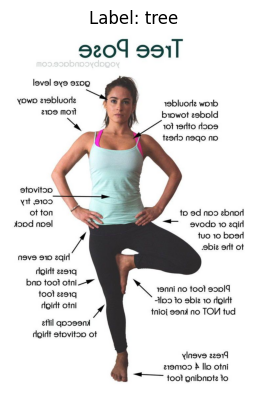

In [21]:
#sample image
sample = train_ds[0]
print(sample)

import matplotlib.pyplot as plt

# Take one sample
sample = dataset["train"][1119]
image = sample["image"]       # the actual picture
label_id = sample["label"]   # this is a number

# Get label names
label_names = dataset["train"].features["label"].names
label_name = label_names[label_id]

# Show image with label name
plt.imshow(image)
plt.title(f"Label: {label_name}")   # shows the real name
plt.axis("off")
plt.show()

In [4]:

#Preprocessing

IMG_SIZE = (160, 160)
def preprocess(example):
    img = example["image"].convert("RGB").resize(IMG_SIZE)
    img = np.array(img, dtype=np.float32) / 255.0 #normalize
    label = int(example["label"])
    return img, label

X_train, y_train = zip(*[preprocess(x) for x in train_ds]) # zip create list of tuples
X_test, y_test   = zip(*[preprocess(x) for x in test_ds])

# convert into numoy array
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test   = np.array(X_test), np.array(y_test)

print("train shape:", X_train.shape, "test shape:", X_test.shape)


c:\Users\HP\Desktop\Machine_Learning\.venv\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train shape: (1813, 160, 160, 3) test shape: (321, 160, 160, 3)


In [5]:

# Data Augmentation

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),])


In [6]:


# Transfer Learning Model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
])

#optimization
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#check summary
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
#early stop
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_yoga_model.h5", save_best_only=True, monitor="val_loss"),
]



In [8]:
# fit model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=15,
                    batch_size=32,
                    callbacks=callbacks)

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.5015 - loss: 1.3213

57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6437 - loss: 0.9590 - val_accuracy: 0.9034 - val_loss: 0.3495
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.8306 - loss: 0.4836

57/57 ━━━━━━━━━━━━━━━━━━━━ 65s 837ms/step - accuracy: 0.8489 - loss: 0.4451 - val_accuracy: 0.9377 - val_loss: 0.2172
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.8705 - loss: 0.3571

57/57 ━━━━━━━━━━━━━━━━━━━━ 78s 762ms/step - accuracy: 0.8930 - loss: 0.3197 - val_accuracy: 0.9626 - val_loss: 0.1583
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8911 - loss: 0.3224

57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 505ms/step - accuracy: 0.9084 - loss: 0.2712 - val_accuracy: 0.9688 - val_loss: 0.1244
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9209 - loss: 0.2197

57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 530ms/step - accuracy: 0.9244 - loss: 0.2193 - val_accuracy: 0.9751 - val_loss: 0.1137
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 474ms/step - accuracy: 0.9283 - loss: 0.2153 - val_accuracy: 0.9688 - val_loss: 0.1138
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9494 - loss: 0.1727

57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 473ms/step - accuracy: 0.9470 - loss: 0.1755 - val_accuracy: 0.9782 - val_loss: 0.0992
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 468ms/step - accuracy: 0.9448 - loss: 0.1639 - val_accuracy: 0.9782 - val_loss: 0.0995
Epoch 9/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9586 - loss: 0.1342

57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 512ms/step - accuracy: 0.9542 - loss: 0.1439 - val_accuracy: 0.9720 - val_loss: 0.0934
Epoch 10/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.9602 - loss: 0.1329

57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 670ms/step - accuracy: 0.9575 - loss: 0.1363 - val_accuracy: 0.9688 - val_loss: 0.0882
Epoch 11/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 646ms/step - accuracy: 0.9575 - loss: 0.1352 - val_accuracy: 0.9626 - val_loss: 0.0991
Epoch 12/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 554ms/step - accuracy: 0.9597 - loss: 0.1279 - val_accuracy: 0.9813 - val_loss: 0.0890
Epoch 13/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 548ms/step - accuracy: 0.9636 - loss: 0.1111 - val_accuracy: 0.9657 - val_loss: 0.1322


In [9]:
# Evaluation
loss, acc = model.evaluate(X_test, y_test)
print("test Accuracy:", acc)
print("test loss:",loss)



11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step - accuracy: 0.9688 - loss: 0.0882
test Accuracy: 0.9688473343849182
test loss: 0.08821778744459152


In [10]:
#Prediction Function
def prepare_image(image_path):
    img = Image.open(image_path).convert("RGB").resize(IMG_SIZE)
    arr = np.array(img, dtype=np.float32) / 255.0
    return np.expand_dims(arr, axis=0)

def predict_pose(image_path):
    arr = prepare_image(image_path)
    pred = model.predict(arr)[0]
    pred_idx = np.argmax(pred)
    return labels[pred_idx], float(pred[pred_idx])

In [23]:
#predict image
test_img = r"C:\Users\HP\Desktop\INTERVIEW\plank.jpg"
pose, conf = predict_pose(test_img)
print(f"Predicted Pose: {pose} ({conf:.2f} confidence)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Predicted Pose: plank (0.93 confidence)


In [14]:
model.save("yoga_model.h5")

In [24]:
import pickle
with open("YogaModel.pkl","wb") as file:
    pickle.dump(history,file)

In [3]:
import tensorflow
print(tensorflow.__version__)

2.20.0


In [ ]:
print(python.__version__

NameError: name 'python' is not defined